In [1]:
!pip install -r ./requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.7/939.7 kB 5.4 MB/s eta 0:00:00a 0:00:01


In [34]:
%load_ext autoreload
import re, time, os, shutil, json
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from PIL import Image
from monai.data import create_test_image_3d, list_data_collate, decollate_batch, pad_list_data_collate
import tempfile
import monai
from monai.data import DataLoader, Dataset 
from monai.networks.layers import Norm
from monai.transforms import (
    LoadImage, EnsureChannelFirst, Spacing,
    RandFlip, Resize, EnsureType,
    LoadImaged, EnsureChannelFirstd,
    Resized, EnsureTyped, Compose, ScaleIntensityd, 
    AddChanneld, MapTransform, AsChannelFirstd, EnsureType, 
    Activations, AsDiscrete, RandCropByPosNegLabeld, 
    RandRotate90d, LabelToMaskd, RandFlipd, RandRotated, Spacingd, RandAffined
)

from monai.transforms.intensity.array import ScaleIntensity
from monai.metrics import DiceMetric
import configdot
import torch
from monai.config import print_config
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
!mkdir -p ./MONAI_TMP

In [7]:
os.environ['MONAI_DATA_DIRECTORY'] = "./MONAI_TMP"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

./MONAI_TMP


# Create dataset

In [8]:
config = configdot.parse_config('configs/config.ini')

In [33]:
print(torch.cuda.is_available())
DEVICE = config.opt.device if hasattr(config.opt, "device") else 1
device = torch.device(DEVICE)
torch.cuda.set_device(DEVICE)

print('Setting GPU#:', DEVICE)
print('Using GPU#:', torch.cuda.current_device())

True
Setting GPU#: 1
Using GPU#: 1


### Loading train-test split


In [43]:
import numpy as np
subjects_list = np.load('./metadata/metadata_fcd_nG.npy', allow_pickle=True).item()

In [42]:
subjects_list

array({'train': array(['n16', 'n49', 'n71', 'n44', 'n80', 'G133', 'n21', 'n67', 'n12',
       'n81', 'n47', 'n61', 'n62', 'n75', 'G180', 'n10', 'n60', 'G258',
       'n64', 'n31', 'n36', 'n11', 'n55', 'G371', 'n26', 'n68', 'n51',
       'G324', 'n17', 'n66', 'n59', 'n15', 'n58', 'n69', 'n33', 'n41',
       'n14', 'n65', 'n52', 'n73', 'G368', 'G081', 'G294', 'G409', 'n27',
       'n40', 'n30', 'n7', 'n70', 'n29', 'n13', 'n74', 'G507', 'n83',
       'n45', 'n78', 'n39', 'n8', 'n22', 'n54', 'n87', 'G256', 'G414',
       'n24', 'n56', 'n28', 'n57', 'n2', 'n23', 'G184', 'n18', 'n53',
       'n38', 'n19', 'n35', 'n3', 'n5', 'n84', 'n79', 'n50', 'n9', 'n25',
       'G044', 'n20', 'n82', 'n48', 'G417'], dtype=object), 'test': array(['n43', 'n72', 'n46', 'n32', 'G061', 'n37', 'n88', 'G150', 'n76',
       'n77'], dtype=object)}, dtype=object)

In [12]:
train_list = subjects_list.item().get('train')
val_list = subjects_list.item().get('test')

In [13]:
len(train_list), len(val_list)

(87, 10)

In [14]:
'''
Checks that features and labels available and returns number of available subjects
'''

images_list = []
subject_list = []
feat_params = config.dataset.features

for i in os.listdir(OUTPUT_DIR):
    sub_ind = re.findall('-(.[a-zA-Z0-9]*|[0-9])', str(i))
    # if sub_ind and not any(x in sub_ind[0] for x in matches): 
    # subjects with 'n', 'G', 'NS', 'C' won't be included
    if sub_ind:
        subject_list.append(sub_ind[0])
        
train_subs_indcs = []
train_files = []

for sub in train_list:
    images_per_sub = dict()
    images_per_sub['image'] = []
    for feat in feat_params:
        map_path = assign_feature_maps(sub, feat)
        if os.path.isfile(map_path):
            images_per_sub['image'].append(map_path)
        else:
            print(f'No feature {feat} for sub {sub} in train data')
            continue
            
    if len(images_per_sub['image']) == len(feat_params):
        seg_path = os.path.join(BASE_DIR, 'preprocessed_data/label_bernaskoni', f'{sub}.nii.gz')
        if os.path.isfile(seg_path):
            images_per_sub['seg'] = seg_path
        else:
            continue
        train_subs_indcs.append(sub)
        train_files.append(images_per_sub)

val_subs_indcs = []
val_files = []

for sub in val_list:
    images_per_sub = dict()
    images_per_sub['image'] = []
    for feat in feat_params:
        map_path = assign_feature_maps(sub, feat)
        if os.path.isfile(map_path):
            images_per_sub['image'].append(map_path)
        else:
            print(f'No feature {feat} for sub {sub} in val data')
            continue
    if len(images_per_sub['image']) == len(feat_params):
        seg_path = os.path.join(BASE_DIR, 'preprocessed_data/label_bernaskoni', f'{sub}.nii.gz')
        if os.path.isfile(seg_path):
            images_per_sub['seg'] = seg_path
        else:
            print(f'No {seg_path} for sub {sub}')
            continue
        val_subs_indcs.append(sub)
        val_files.append(images_per_sub)

print(f"Train set length: {len(train_files)}\nTest set length: {len(val_files)}")

Train set length: 87
Test set length: 10


### Transformation and Augmentation

In [15]:
assert config.default.interpolate
spatial_size_conf = tuple(config.default.interpolation_size)

if config.opt.augmentation:
    rot_range = config.opt.rotation_range

    train_transf = Compose(
        [
            LoadImaged(keys=["image", "seg"]),
            EnsureChannelFirstd(keys=["image", "seg"]),
            RandRotated(keys=["image", "seg"], 
                        range_x=rot_range, 
                        range_y=rot_range, 
                        range_z=rot_range, 
                        prob=0.5),
            RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=0),
            Resized(keys=["image", "seg"], spatial_size=spatial_size_conf, mode=('area', 'nearest')),
            Spacingd(keys=['seg'], pixdim=1.0),
            ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0, channel_wise=True),
            EnsureTyped(keys=["image", "seg"], dtype=torch.float),
        ]
    )

    val_transf = Compose(
        [
            LoadImaged(keys=["image", "seg"]),
            EnsureChannelFirstd(keys=["image", "seg"]),
            Resized(keys=["image", "seg"], spatial_size=spatial_size_conf, mode=('area', 'nearest')),
            Spacingd(keys=['seg'], pixdim=1.0),
            ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0, channel_wise=True),
            EnsureTyped(keys=["image", "seg"], dtype=torch.float),
        ]
    )
    
else:
    raise NotImplementedError

### Visualization

In [16]:
check_dataset = Dataset(data=train_files, transform=train_transf)

In [17]:
def get_label(path):
    '''
    Extracts label from path, e.g.:
    '/workspace/RawData/Features/preprocessed_data/label_bernaskoni/n16.nii.gz' -> 'n16'
    '''
    return path.split('/')[-1].split('.')[0]

In [18]:
check_dataset[0]['seg'].shape, check_dataset[0]['image'].shape

(torch.Size([1, 128, 128, 128]), torch.Size([2, 128, 128, 128]))

In [20]:
check_batch_size = 10
check_loader = DataLoader(check_dataset, 
                          batch_size=check_batch_size, 
                          num_workers=0, 
                          collate_fn=list_data_collate, 
                          pin_memory=torch.cuda.is_available(),
                          shuffle=False
                          )

check_data = monai.utils.misc.first(check_loader)

In [21]:
print(check_data["image"].shape, check_data["seg"].shape)

torch.Size([10, 2, 128, 128, 128]) torch.Size([10, 1, 128, 128, 128])


image shape: torch.Size([2, 128, 128, 128])


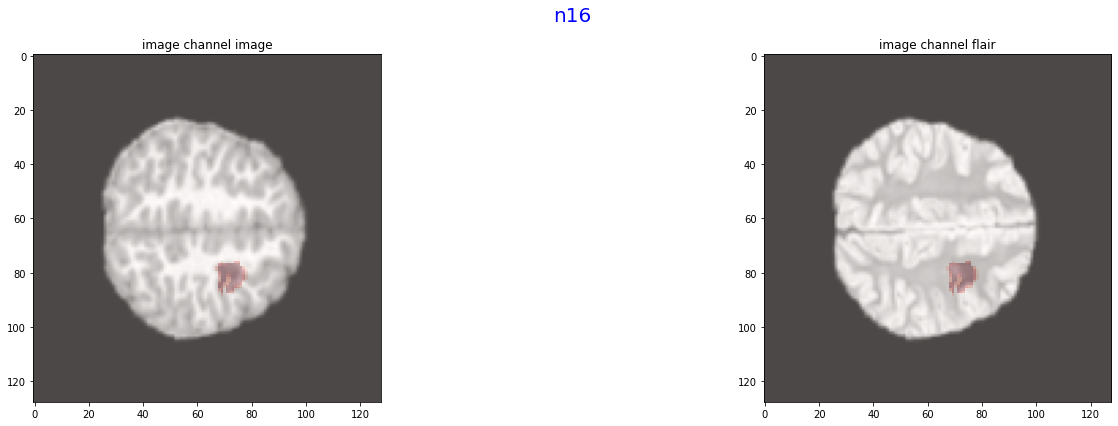

image shape: torch.Size([2, 128, 128, 128])


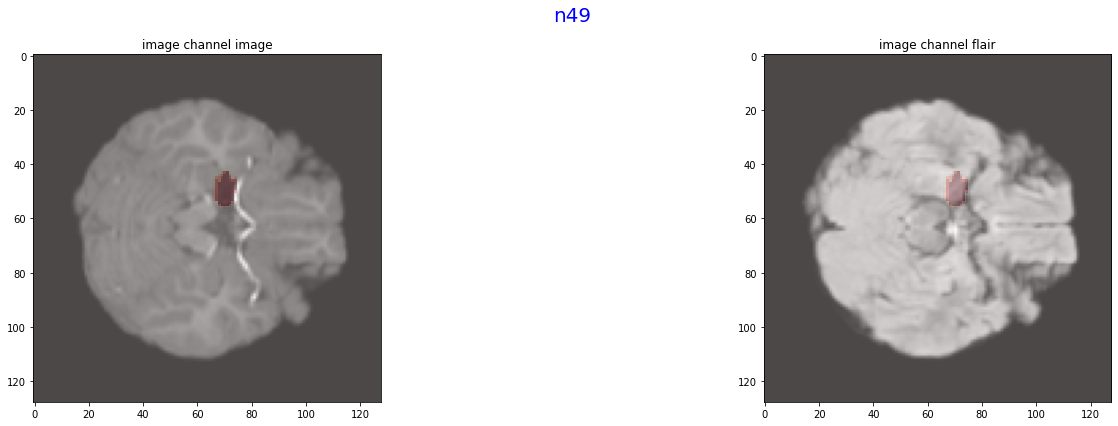

image shape: torch.Size([2, 128, 128, 128])


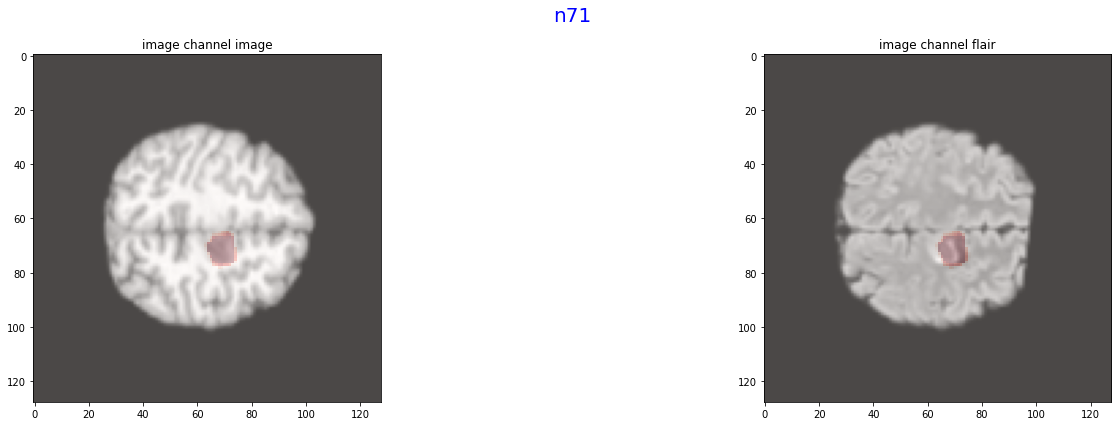

image shape: torch.Size([2, 128, 128, 128])


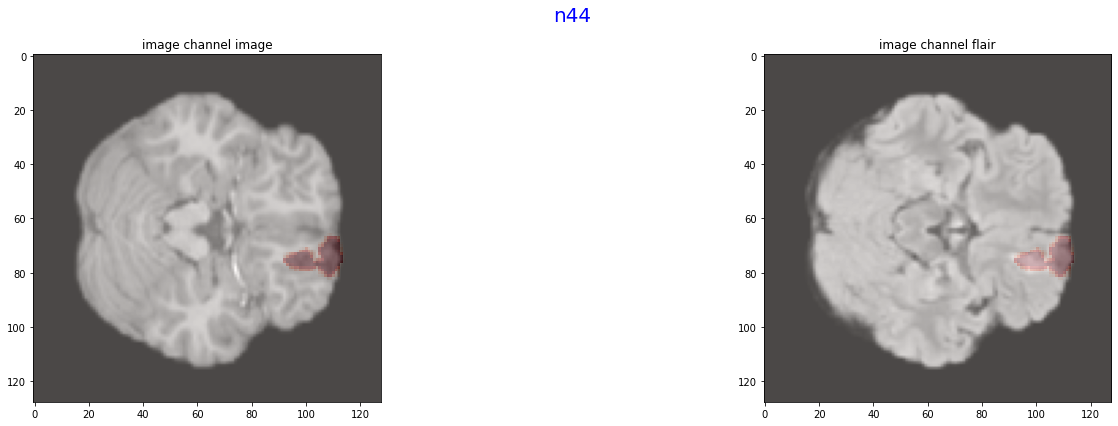

image shape: torch.Size([2, 128, 128, 128])


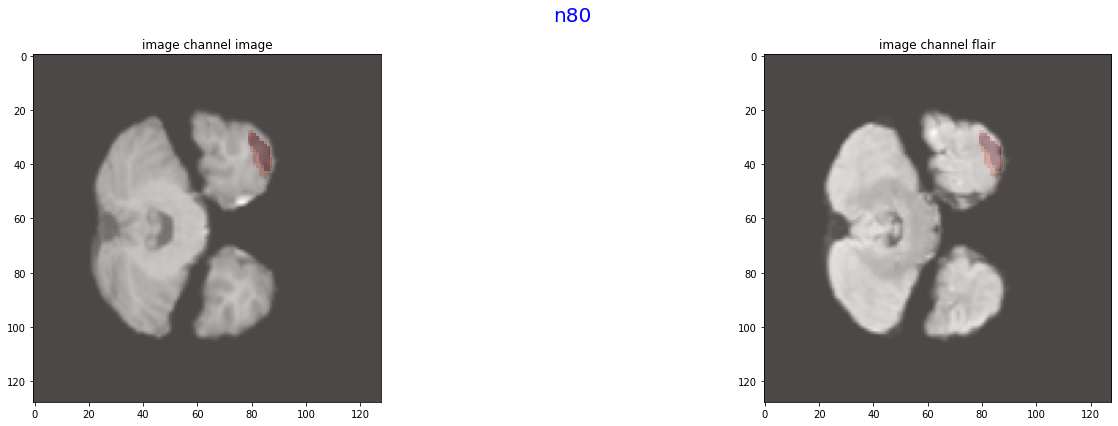

image shape: torch.Size([2, 128, 128, 128])


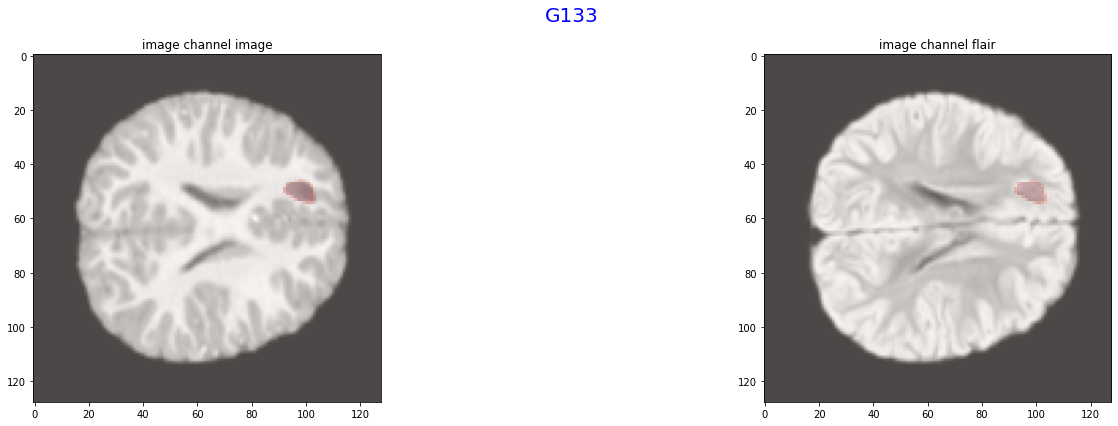

image shape: torch.Size([2, 128, 128, 128])


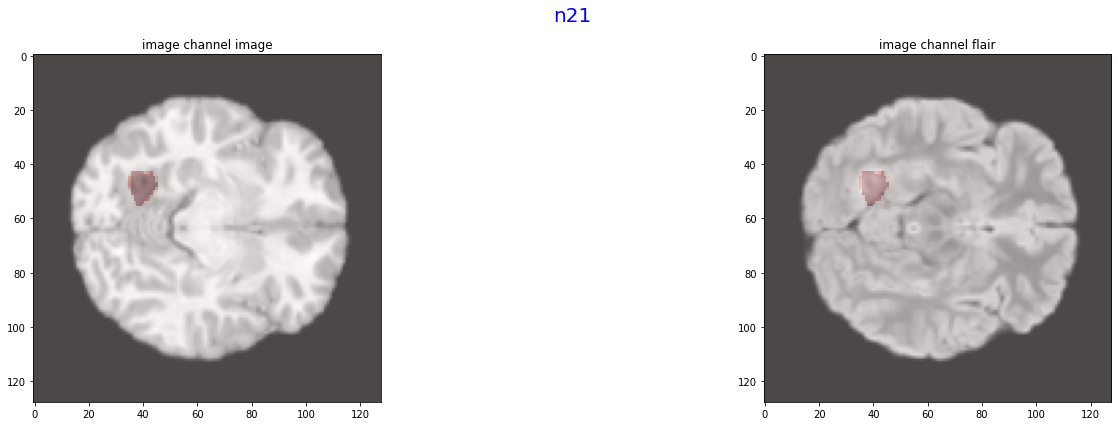

image shape: torch.Size([2, 128, 128, 128])


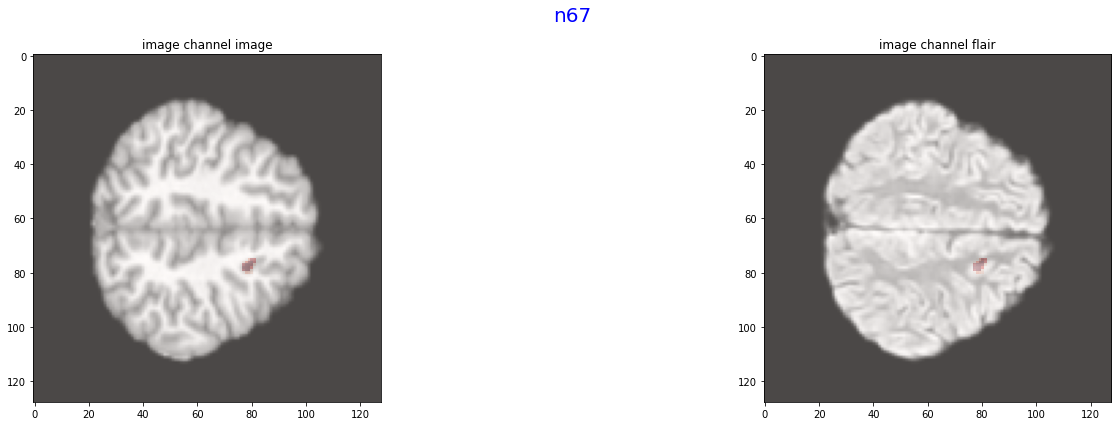

image shape: torch.Size([2, 128, 128, 128])


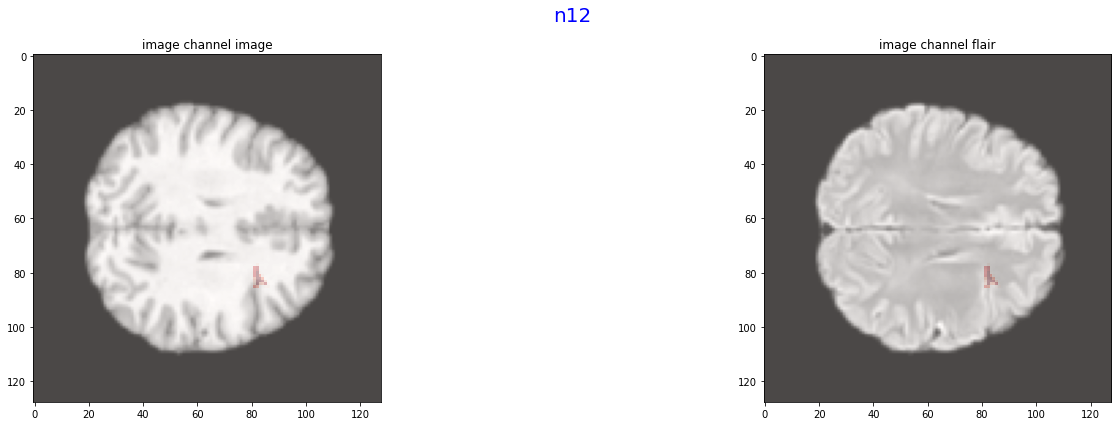

image shape: torch.Size([2, 128, 128, 128])


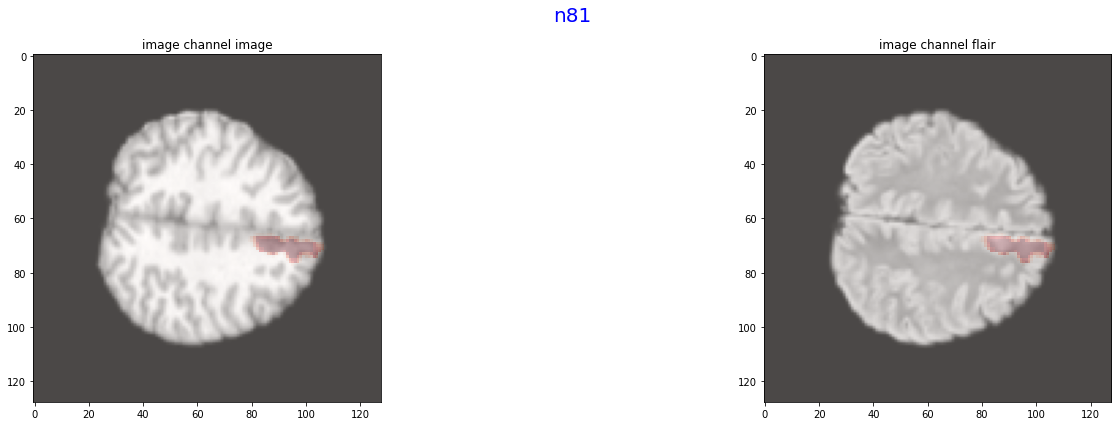

In [22]:
for k in range(check_batch_size):
    
    image = check_data['image'][k]
    seg = check_data['seg'][k]
    label = get_label(check_dataset.data[k]['seg'])
    
    print(f"image shape: {image.shape}")
    
    num_of_channels = len(feat_params)
    # choose z-coord where there is a label maximum over other axes
    label_pos = (seg > 0).sum(dim=(0,1,2)).argmax().item()

    fig = plt.figure("image", (24, 6))
    for i in range(num_of_channels):
        plt.subplot(1, num_of_channels, i + 1)
        plt.title(f"image channel {feat_params[i]}")
        plt.imshow(image[i,:,:,label_pos], cmap="gray")
        plt.imshow(seg[0,:,:,label_pos],interpolation='none', cmap='Reds', alpha=0.3)
    
    fig.suptitle(label, fontsize=20, color='blue')
    plt.tight_layout()
    plt.show()

# Setup dataloaders

In [23]:
# training dataset
train_ds = monai.data.Dataset(data=train_files, transform=train_transf)
train_loader = DataLoader(
    train_ds,
    batch_size=config.opt.train_batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=list_data_collate,
    pin_memory=torch.cuda.is_available(),
)

# validation dataset
val_ds = monai.data.Dataset(data=val_files, transform=val_transf)
val_loader = DataLoader(val_ds, 
                        batch_size=config.opt.val_batch_size, 
                        num_workers=0, 
                        collate_fn=list_data_collate,
                        shuffle=False # important not to shuffle, to ensure label correspondence
                        )

### Before augmentation

In [24]:
# from nilearn.plotting import plot_img
# ind = 0
# plot_img = plot_img(train_files[ind]['seg'],
#          bg_img=train_files[ind]['image'][0],
#          threshold=0.1, alpha=0.5, display_mode='z')
# plot_img
# print(plot_img.cut_coords) # get coordinate of z where lesion center mass

### After augmentation

In [25]:
# plt.figure(figsize=(30,30))
# for i in range(7):
#     plt.subplot(1, 10, i+1)
#     item = train_loader.dataset[ind]
#     image, segme = item["image"], item["seg"]
#     lab_loc = round(np.where(segme>0)[3].shape[0] / 2)
#     lab_pos = np.where(segme>0)[3][lab_loc]
#     plt.imshow(np.rot90(image[0,:, :, lab_pos]), cmap='gray')
#     plt.imshow(np.rot90(segme[0,:, :, lab_pos]), cmap="Reds", alpha=0.4)
#     plt.title("seg overlay")
# plt.show()

# Training

In [ ]:
# best_val_preds = {}
# for label in os.listdir(val_preds_path):
#     val_preds_label_path = os.path.join(val_preds_path, label)
#     best_val_preds[label] = torch.load(val_preds_label_path)[0,0]

experiment_name = 'v2v-AUG_YARKIN_onesite-subs_autocast_DICE-loss_lr-1e-3_t1+flair+thick+blurt1@22.06.2022-19'
val_preds_path = os.path.join('./logs',experiment_name, 'best_val_preds')

best_val_preds = {}
for label in os.listdir(val_preds_path):
    experiment_name = 'v2v-AUG_YARKIN_onesite-subs_autocast_DICE-loss_lr-1e-3_t1+flair+thick+blurt1@22.06.2022-19'
    best_val_preds_path = os.path.join(val_preds_path, label)
    best_val_preds[label] = torch.load(best_val_preds_path)

In [ ]:
best_val_preds.keys()

In [ ]:
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


ind_pred = str(29) # index for best val score tensor
ind = [i for i,x in enumerate(val_subs_indcs) if x == ind_pred][0]
item = val_loader.dataset[ind]
image, segme = item["image"], item["seg"]
#label_tensor_predicted = val_loader.dataset[ind]['seg'].clone().detach()
new_arr = best_val_preds[ind_pred][0][0]
#new_arr = np.where(best_val_preds[ind_pred][0][0] > 0.1, best_val_preds[ind_pred][0][0], 0)
lab_loc = round(np.where(segme>0)[3].shape[0] / 2)
lab_pos = np.where(segme>0)[3][lab_loc]

plt.figure(figsize=(30,7))
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(np.rot90(image[0,:, :, i*6]), cmap='gray')
    plt.imshow(np.rot90(new_arr[:, :, i*6].astype(np.float)), cmap="jet", alpha=0.5)
    plt.imshow(np.rot90(segme[0,:, :, i*6]), cmap="Greens", alpha=0.4)
    plt.title(f"Axial Image Slice # {i*12}")
plt.show()

plt.figure(figsize=(30,7))
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(np.rot90(image[0,:, i*6, :]), cmap='gray')
    plt.imshow(np.rot90(new_arr[:, i*6, :].astype(np.float)), cmap="jet", alpha=0.5)
    plt.imshow(np.rot90(segme[0,:, i*6, :]), cmap="Greens", alpha=0.4)
    plt.title(f"Sagital Image Slice # {i*12}")
plt.show()

plt.figure(figsize=(30,7))
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(np.rot90(image[0,i*6, :, :]), cmap='gray')
    plt.imshow(np.rot90(new_arr[i*6, :, :].astype(np.float)), cmap="jet", alpha=0.5)
    plt.imshow(np.rot90(segme[0,i*6, :, :]), cmap="Greens", alpha=0.4)
    plt.title(f"Sagital Image Slice # {i*12}")
plt.show()


dice_metric = DiceMetric(include_background=False)
dice_metric(y_pred=pred_tensor, y=segme[0])
pred_tensor = torch.Tensor(new_arr)
metric = dice_metric.aggregate().item()
print(f"Dice {metric}")

#plt.figure(figsize=(20,7))
#sns.distplot(best_val_preds[ind_pred][0][0])